In [1]:
using Plots
using LaTeXStrings
using LinearAlgebra
using Turing
using ReverseDiff
using BenchmarkTools
using Turing
using ReverseDiff
# using FFTW

In [2]:
function fft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(-2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

function ifft(x::AbstractVector)
    N = length(x)
    @assert ispow2(N) "Length must be a power of 2"
    # Make a working copy
    y = complex.(copy(x))

    # 1) Bit‑reversal permutation
    bits = Int(floor(log2(N)))
    for i in 0:(N-1)
        j = bitreverse(i) >>> (sizeof(Int)*8 - bits)
        if j > i
            y[i+1], y[j+1] = y[j+1], y[i+1]
        end
    end

    # 2) Cooley‑Tuk decimation‑in‑place
    m = 1
    while m < N
        half = m
        m *= 2
        # principal m‑th root of unity: exp(-2πi/m)
        wm = cis(2π/m)
        for k in 1:m:N
            w = one(wm)
            for j in 0:(half-1)
                u = y[k + j]
                t = w * y[k + j + half]
                y[k + j]          = u + t
                y[k + j + half]   = u - t
                w *= wm
            end
        end
    end

    return y
end

ifft (generic function with 1 method)

In [3]:
function fft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = fft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = fft(view(B, y, :))
    end
    return B
end

function ifft(A::AbstractMatrix)
    Ny, Nx = size(A)
    @assert ispow2(Ny) && ispow2(Nx) "Both dimensions must be powers of 2"
    B = copy(A)

    # 1) FFT down each column
    @inbounds @simd for x in 1:Nx
        B[:, x] = ifft(view(B, :, x))
    end

    # 2) FFT across each row of the intermediate result
    @inbounds @simd for y in 1:Ny
        B[y, :] = ifft(view(B, y, :))
    end
    return B
end

ifft (generic function with 2 methods)

In [4]:
function custom_fftshift(A::AbstractMatrix)
    n1, n2 = size(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    idx2 = vcat((div(n2,2)+1):n2, 1:div(n2,2))
    return A[idx1, idx2]
end
function custom_fftshift(A::AbstractVector)
    n1 = length(A)
    idx1 = vcat((div(n1,2)+1):n1, 1:div(n1,2))
    return A[idx1]
end

function fftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(fft(custom_fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    return custom_fftshift(ifft(custom_fftshift(B)))./(reduce(*,size(B)))
end

ifftnshift (generic function with 1 method)

In [47]:
function Wavelength(E::T)::T where T <: Real
    hc::T = 12.398 #keV*Angstrom
    # h = 6.582119e-16 #eV*sec
    # mc2 = 511 #keV
    E₀::T = 511.0 #keV
    return hc/sqrt(E*(2*E₀ + E))
end


function Focus(E::T, Cs::T, nᵢ=1)::T where T <: Real
    return sqrt((2*nᵢ-0.5)*Cs*Wavelength(E))
end
kmax(E, Cs) = (6/((Cs*Wavelength(E)^3)))^(1/4)

Diff_Image(image, c=0.1) = @. log1p(c*abs(image))

Diff_Image (generic function with 2 methods)

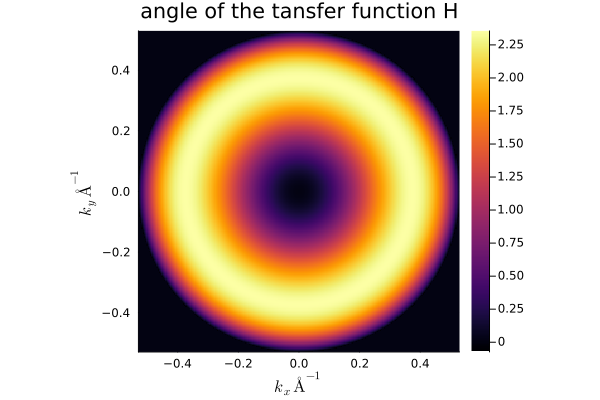

In [21]:
E = 300.0 #keV
Cs = 1 #mm
Cs = Cs * 1e7 #convert to Angstroms

N = 2^8
physical_scale = 1
camera_scale = 2

upper = (N-1)/2 + 0.1
lower = (-N+1)/2
kx = collect(lower:1:upper)
ky = collect(lower:1:upper)

k = @. sqrt(kx'^2 + ky^2)
disk = k.<=N/2

kx = kx./maximum(kx).*kmax(E, Cs)
ky = ky./maximum(ky).*kmax(E, Cs)
k = @. sqrt(kx'^2 + ky^2)


Δk = kx[2] - kx[1]
L = 1/Δk
ΔL = L/N

x = collect(range(-L/2, L/2, N))
y = collect(range(-L/2, L/2, N))


λ(E) = Wavelength(E)
Δf(E, Cs) = Focus(E, Cs)
χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
# H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
H = @. exp(-1im*χ(k)*disk)*disk
# H = fill(1.0, N, N)
heatmap(kx, ky, angle.(H), title="angle of the tansfer function H",  
        xlabel=L"k_x\, Å^{-1}", ylabel=L"k_y\, Å^{-1}", aspect_ratio=1)
xlims!(kx[1], kx[end])
ylims!(ky[1], ky[end])

Free space evolution
\begin{align*}
    \psi(x,y,z) &= e^{ikz} \psi_0(x,y)*D(x,y,z)\\
    D(x,y,z) &= \frac{1}{i\lambda z} e^{i\frac{\pi}{\lambda z} ((x-x')^2 + (y-y')^2)}\\
    \psi(x,y,z) &= e^{ikz} \int dx'dy'\, \psi_0(x',y') \frac{1}{i\lambda z} e^{i\frac{\pi}{\lambda z} ((x-x')^2 + (y-y')^2)}\\
\end{align*}

The values that with be changing are 
\begin{align*}
    \Delta f_i, \quad C_{s,i}, \quad \Delta\vec{r}_{g2}, \quad \Delta E 
\end{align*}
where $i\in \{1,2,3\}$ for the three lenes; $\Delta\vec{r}$ represents the transverse misalignment of the second grating $g_2$; $\Delta E$ is the energy distribution of the imaged electrons. The transverse alignment of the first grating shouldn't matter since its fourier transform should be the same. 

For the next run of simulations, I will center the distribution of $\Delta f$ about zero. However, optimal alignment may have $\Delta f != 0$ e.g. scherzer's conditions in which the defocusing is set such that the minimum abberations are achieved.


Although I am incorporating abberations caused by misalignment, I am currently not including the possibility that the lens is off-centered, rendering alignment impossible/impractical. I may need to account for the fact the three lens may not be exactly between intermediate objects.

\begin{equation}
    \alpha_{max} = \left(\frac{6\lambda}{C_s} \right)^{1/4}
\end{equation}
$E ~ N(E_0, 0.4 eV )$

In [22]:
α_max = (6*λ(E)/Cs)^(1/4)
E_σ = 0.4/1000 #keV
α_sigma = (6*λ(E + E_σ)/Cs)^(1/4)

0.01042513153110659

In [23]:
err_abs = abs(α_max - α_sigma)
err_rel = err_abs/α_max
println("Maximum aberration: ", α_max, "  |  σ: ", α_sigma)
println("Absolute error: ", err_abs, "  |  Relative error: ", err_rel)

Maximum aberration: 0.010425133662921443  |  σ: 0.01042513153110659
Absolute error: 2.131814853117975e-9  |  Relative error: 2.0448801157342424e-7


This error is absurdly small. Furthermore, I checked the abs and rel err for the interaction parameter and it produced equally samll errs (both 1e-7). Therefore, the distribution of the energy speard will not be considered. However, the error of the center of the distribution, caused by miss reporting of the aperatus, may be contribute significantly. I should ask Kayla if she bayesian operimizes (BO) for the energy and/or the accelerating voltage. 

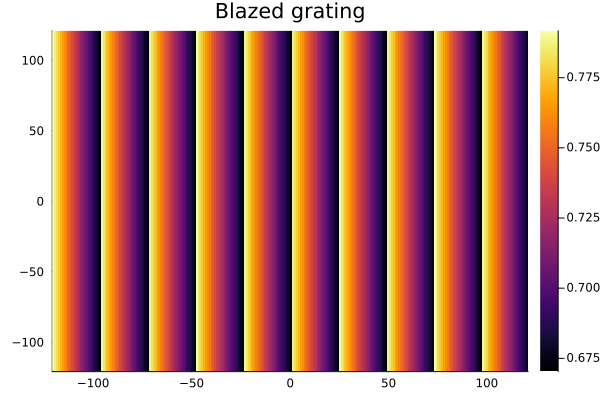

In [24]:
λ(E::Real) = 12.398/sqrt(E*(2*511 + E)) #Angstroms
σ(E::Real) = 2π/(λ(E)*E) * (511 + E)/(2*511 + E) # per Angstroms
function Si3N4_Grating_Parameters(E::T) where T <: Real
    #given from CJW thesis in units of per nm
    σU = 0.15 
    α = 0.008
    
    

    λ_nm = λ(E)/10 # convert to nm from Angstroms
    κ = α * (λ_nm/(2*π)) # this is the attenuation coefficient 

    # I assume that CJW uses 300 KeV for his values
    σ_cjw = σ(300) * 10 # per nm 
    U_mip = σU/σ_cjw 
    return (U_mip, κ)
end

function Blazed_Grating(p; N=N, mill_depth=208, thickness=500, E::Real=E)
    """
    Create a blazed grating transmission function for a given energy E.
    """
    
    U_mip, κ = Si3N4_Grating_Parameters(E)

    """
    creatings the 1D grating function (depth(x)), slopes upwards to the right
    """
    xs = collect(range(0, 1, length=N))
    d0 = thickness - mill_depth
    g_1d = @. mod(p*mill_depth*xs, mill_depth+1) + d0



    t_1d = @. cis((σ(E)*U_mip+1im*κ*2π/λ(E))*g_1d);
    t_2d = repeat(t_1d', N, 1)
    return t_2d
end


ρ2 = @. x'^2 + y^2
t1 = Blazed_Grating(10)
heatmap(x, y, abs.(t1), title="Blazed grating")

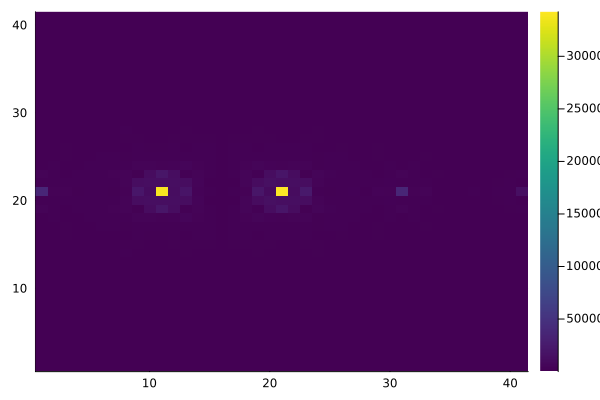

In [44]:
data = abs2.(fftnshift(t1.*H))
shift = 20
ctr = N÷2 + 1
mask = ctr-shift:ctr+shift, ctr-shift:ctr+shift
heatmap(data[mask...], color=:viridis)

In [ ]:
@model function single_propagation(y::AbstractMatrix{AbstractFloats}=data, params::AbstractVector{Float64})
    Cs_ctr, E_ctr, Δf_ctr, Cs_σ, E_σ, Δf_σ = params

    σ ~ Exponential(1)
    Cs ~ Normal(Cs_ctr, Cs_σ)
    E ~ Normal(E_ctr, E_σ)
    Δf ~ Normal(Δf_ctr, Δf_σ)


    χ(k) =@. π*λ(E)*k^2*(0.5*Cs*λ(E)^2*k^2 - Δf(E, Cs))
    # H = @. phonycomplex(cos(χ(k)*disk)*disk, sin(-χ(k)*disk)*disk);
    H = @. exp(-1im*χ(k)*disk)*disk
    @inbounds @simd for i in eachindex(y)
        Turing.@addlogprob! -1/(2σ^2) * (y[i] - buff[i])^2
    end
end

┌ Warning: Model definition seems empty, still continue.
└ @ DynamicPPL /home/nicolas/.julia/packages/DynamicPPL/oX6N7/src/compiler.jl:665


UndefVarError: UndefVarError: `AbstractFloats` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [26]:

println(size(ρ2))
function fresnel_propagator(x, y, z, λ, x0=0.0, y0=0.0)
    
    phase = k/(2*z)*((x .- x0').^2 .+ (y .- y0').^2)
    return prefactor * exp.(im * phase)
end

mutable struct caching{T<:AbstractMatrix{ComplexF64}}
    Arr1::T
    Arr2::T
    Arr3::T
    Arr4::T
end


buffer = caching(
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N)
)



function Transfer_Function()

function propagate(ψ0,)

end

# mutable struct pf_chache
#     prefactor::AbstractMatrix
#     ft_arg::AbstractMatrix
#     ft::AbstractMatrix
#     output::AbstractMatrix
# end
mutable struct pf_chache{T<:AbstractMatrix{ComplexF64}}
    prefactor::T
    ft_arg::T
    ft::T
    output::T
end
pfc = pf_chache(
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N),
    Matrix{ComplexF64}(undef, N, N)
)

function propagate_field(ψ0, z, λ, ρ2=ρ2)
    prefactor = @. -1im*cis(2π/(λ*z))/ (λ*z) * cis(π * ρ2 /(λ*z))
    fft_arg = @. ψ0 * cis(π * ρ2 /(λ*z))
    ft = fftnshift(fft_arg)
    ψ_propagated = @. prefactor * ft
   return ψ_propagated
end

(256, 256)


Base.Meta.ParseError: ParseError:
# Error @ /home/nicolas/Desktop/julia_functions/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl:57:4
   return ψ_propagated
end
#  └ ── Expected `end`

In [27]:
@benchmark propagate_field(ones(ComplexF64, N, N), 1.0, λ(E), ρ2)

UndefVarError: UndefVarError: `propagate_field` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [28]:
function propagate_fieldv2(ψ0, z, λ, ρ2=ρ2)
    factor = @. $fftnshift(ψ0 * cis(π * ρ2 /(λ*z)))
   return @. -1im*cis(2π/(λ*z))/ (λ*z) * cis(π * ρ2 /(λ*z)) * factor
end

propagate_fieldv2 (generic function with 2 methods)

In [29]:
@benchmark propagate_fieldv2(ones(ComplexF64, N, N), 1.0, λ(E), ρ2)

BenchmarkTools.Trial: 731 samples with 1 evaluation per sample.
 Range (min … max):  5.364 ms …  15.471 ms  ┊ GC (min … max):  0.00% … 8.40%
 Time  (median):     6.688 ms               ┊ GC (median):    12.19%
 Time  (mean ± σ):   6.821 ms ± 919.525 μs  ┊ GC (mean ± σ):   9.62% ± 9.40%

   ▁▃▃ ▂█▂▃▂▃▄█▃▇█▇▅▄▃▂▄▂▂▂▄▂▁▅▃▄▆▂ ▂                          
  ▂███▄████████████████████████████▇█▆▅▄▆▅▄▄▃▅▄▃▂▃▁▂▂▂▃▂▂▃▁▁▂ ▅
  5.36 ms         Histogram: frequency by time        9.47 ms <

 Memory estimate: 11.06 MiB, allocs estimate: 3094.

In [30]:
using FFTW
function fftnshift(A::AbstractArray)
    B = copy(A)
    return fftshift(fft(fftshift(B)))
end
function ifftnshift(A::AbstractArray)
    B = copy(A)
    # Ny, Nx = size(B)
    return ifftshift(ifft(ifftshift(B)))
end

function fftnshift!(A::AbstractArray, Storage::AbstractArray)
    return fftshift!(fft!(fftshift!(A)))
end
function ifftnshift!(A::AbstractArray)
    return ifftshift!(ifft!(ifftshift!(A)))
end

ifftnshift! (generic function with 1 method)

In [31]:
P = plan_fft(ones(ComplexF64, N, N))

FFTW forward plan for 256×256 array of ComplexF64
(dft-rank>=2/1
  (dft-vrank>=1-x256/1
    (dft-ct-dit/16
      (dftw-direct-16/8 "t3fv_16_avx2_128")
      (dft-direct-16-x16 "n2fv_16_avx2_128")))
  (dft-vrank>=1-x256/1
    (dft-ct-dit/16
      (dftw-direct-16/8 "t3fv_16_avx2_128")
      (dft-directbuf/18-16-x16 "n1fv_16_avx2"))))

In [32]:
typeof(ρ2)

Matrix{Float64} (alias for Array{Float64, 2})

In [33]:
using LoopVectorization
function propagate_fieldv3!(ψ0, z, λ, 
    ρ2::AbstractMatrix{<:AbstractFloat}=ρ2, 
    pfc::pf_chache{<:AbstractMatrix{ComplexF64}}=pfc,
    P=P)    
    
    prefactor = pfc.prefactor
    ft_arg = pfc.ft_arg
    ft = pfc.ft
    ψ_propagated = pfc.output
    
    # prefactor = Matrix{ComplexF64}(undef, N, N)
    # ft_arg = Matrix{ComplexF64}(undef, N, N)
    # ft = Matrix{ComplexF64}(undef, N, N)
    # ψ_propagated = Matrix{ComplexF64}(undef, N, N)
    inv_λz = inv(λ*z)
    # for i ∈ eachindex(ρ2)
    #     arg = π * ρ2[i] / (λ*z)
    #     prefactor[i] = -im/ (λ*z) * cis(2π/(λ*z) + arg) 
    #     ft_arg[i] = ψ0[i] * cis(arg)
    # end
    # @fastmath @inbounds @simd for i ∈ eachindex(ρ2)
    #     arg = π * ρ2[i] * inv_λz
    #     prefactor[i] = -im*inv_λz * cis(2π*inv_λz + arg) 
    #     ft_arg[i] = ψ0[i] * cis(arg)
    # end

    scaler = -im*inv_λz*cis(2π*inv_λz)
    # @. ft = cis((π * ρ2 * inv_λz))
    # @fastmath @inbounds @simd for i ∈ eachindex(ρ2)
    #     # arg = π * ρ2[i] * inv_λz
    #     # s, c = sincos(arg)
    #     # cis_arg = complex(c, s)
    #     # cis_arg = cos(arg)
    #     prefactor[i] = scaler * ft[i]
    #     ft_arg[i] = ψ0[i] * ft[i]
    #     # prefactor[i] = scaler * cis_arg
    #     # ft_arg[i] = ψ0[i] * cis_arg
    # end
    @fastmath @inbounds @simd for i ∈ eachindex(ρ2)
        arg = π * ρ2[i] * inv_λz
        # s, c = sincos(arg)
        # cis_arg = complex(c, s)
        # cis_arg = cis(arg)
        # prefactor[i] = scaler * cis_matrix[i]
        # ft_arg[i] = ψ0[i] * cis_matrix[i]
        # prefactor[i] = scaler * cis_arg
        # ft_arg[i] = ψ0[i] * cis_arg
    end
    # pfc.ft .= fftnshift!(ft_arg)
   return nothing
end

UndefVarError: UndefVarError: `pf_chache` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [34]:
ψ0 = ones(ComplexF64, N, N)
λ_const = λ(E)
@benchmark propagate_fieldv3!(ψ0, 1.0, λ_const)

UndefVarError: UndefVarError: `pfc` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

lets taylor expand z abound f. $z>>\rho>>\lambda$, the exponent is much less than 1 given the fresnel condition
\begin{align*}
    \exp\left[{i\frac{\pi}{\lambda z} (x^2+y^2)}\right] &= \exp\left[i\frac{\pi}{\lambda} (x^2+y^2)(\frac{1}{f} - \frac{1}{f^2}\Delta z)\right]
\end{align*}